# Exponential Growth

Malthus was one of the first to stress exponential population growth back in 1798. The Malthusian growth model is a differential equation that describes a population growing at a constant unrestricted rate. This example starts with the population-level differential equation and then shows how to create the same system as an IEBM.

## Ordinary Differential Equation

The Malthusian growth model can be written as a differential equation,

\begin{equation*}
\frac{dN}{dt} = rN(t)
\end{equation*}

where a population, $N$, increases unrestrictedly in size based on a growth rate, $r$. The growth rate is a per capita measure of the difference between *birth* and *death* rates, which is important later when creating the same event-based system. There is a simple solution to this differential equation, 

\begin{equation*}
\ N(t) = N_0 e^{rt}
\end{equation*}

based on an initial population size, $N_0$. Future examples need integration, so for posterity, here's how to integrate in Python. If a population has a growth rate of 0.001 and a starting size of 500, their exponential growth would look like:

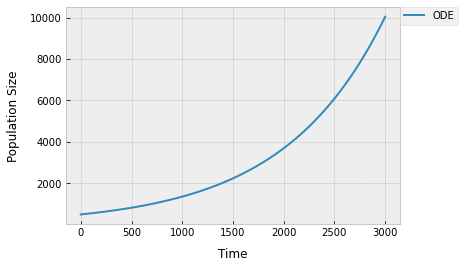

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from scipy import integrate

# set parameters
growth_rate = 0.001
init_size = 500
ode_times = np.linspace(0, 3000, 100) # inference times

# create exponential growth equation as a function of N
def dN_dt(N, t=0):
    return growth_rate * N[0]

# integrate growth equation
X, info = integrate.odeint(dN_dt, init_size, ode_times, full_output=True)
# format and store results
ode_pop, = X.T

# plot
fig, ax = plt.subplots()
ax.plot(ode_times, ode_pop, label='ODE')
ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()

## Indiviual-Level EBM
We are going to build a 2D population that grows exponentially, so things like overlapping individuals are possible.

## Single Simulation

In [2]:
# start by importing required classes
import sys
sys.path.append('../')
from iebm.populations.population2D import Population2D
from iebm.traits.static_trait import StaticTrait
from iebm.events.birth import BirthEvent
from iebm.events.death import DeathEvent
from iebm.simulation import Simulation

In [3]:
# First lets create an empty 2D population. Each individual contains only a unique ID and x-y positions (even though not really needed in this example)

# starting size
init_size = 500

exp_pop = Population2D(name='exp_pop', # unique name (important when there's multiple populations)
                       init_size=init_size, # the initial size of the population
                       xdim=500, ydim=500) # the environment sizes 

In [4]:
# Next, the population needs the list of traits for the birth event and the death event.
# A birth event requires one specific trait: birth_rate 
# The birth rate is the population-level per capita birth rate. 
# Similarly, a death event requires a population-level per capita death rate as a trait.

# set parameters to have same growth rate (0.001) as the differential equation example
birth_rate = 0.0011
death_rate = 0.0001

# The list of traits contain tuples. 
# The first element in the tuple is the necessary Trait module. 
# The second element is a parameter dictionary necessary to instantiate the Trait module.
# Instantiation is done within the Population, so the trait instance knows which population it belongs to.
# There is only one Trait module at the moment, but this approach easily allows for others.
trait_list = [(StaticTrait, {'name' : 'birth_rate', 
                             'value' : birth_rate}), 
              (StaticTrait, {'name' : 'death_rate', 
                             'value' : death_rate})]
# add the traits to the population
exp_pop.add_traits(trait_list)

In [5]:
# Finally, the population needs the actual birth event and death event.
# The time to each individuals next birth/death event is drawn from an exponential distribution with a scale set as the population-level birth/death rate.

# The event_list follows the same structure as the Trait list: tuples of (module, parameter dictionary)
# Event instances require the current simulation time, this way new events could be added anytime to populations 
event_list = [(BirthEvent, {'name' : 'birth',
                            'is_primary' : True,
                            'current_time' : 0}),
              (DeathEvent, {'name' : 'death', 
                            'is_primary' : True,
                            'current_time' : 0})]
# add events
exp_pop.add_events(event_list)

In [6]:
%%time
# Takes a few seconds

# Add the exp_pop to a dictionary 
pop_dict = {str(exp_pop) : exp_pop}

# Create the simulation with the population dictionary
sim = Simulation(pop_dict)

# Run the simulation
sim.run(3000)

# Store results
iebm_pop = sim.population_history[str(exp_pop)]
iebm_times = sim.time_history

CPU times: user 43.2 s, sys: 63.6 ms, total: 43.3 s
Wall time: 5.52 s


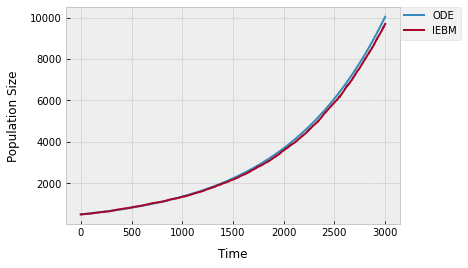

In [7]:
# Plot to see we get the same results
# The slight differences are due to stochasticity in an IEBM
# Re-run to see slightly different IEBM results
fig, ax = plt.subplots()
ax.plot(ode_times, ode_pop, label='ODE')
ax.plot(iebm_times, iebm_pop, label='IEBM')
ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()

## Multiple Simulations

We can run a bunch of simulations to show that indeed, on average, the IEBMs have the same dynamics as the ODE

In [8]:
# datatable defaults to multithread
# only want single thread per parallel simulations
import datatable as dt
dt.options.nthreads = 1

from multiprocessing import Pool
from tqdm.auto import tqdm

In [9]:
# function is the same steps as the single simulation above, just combined
def simulation_func(init_size, xdim, ydim, birth_rate, death_rate, runtime):
    
    exp_pop = Population2D(name='exp_pop', # unique name (important when there's multiple populations)
                           init_size=init_size, # the initial size of the population
                           xdim=xdim, ydim=ydim) # the environment sizes 

    trait_list = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : birth_rate}), 
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : death_rate})]
    exp_pop.add_traits(trait_list)
    
    event_list = [(BirthEvent, {'name' : 'birth',
                                'is_primary' : True,
                                'current_time' : 0}),
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : True,
                                'current_time' : 0})]
    # add events
    exp_pop.add_events(event_list)
    
    # add the exp_pop to a dictionary 
    pop_dict = {str(exp_pop) : exp_pop}

    # create the simulation with the population dictionary
    sim = Simulation(pop_dict)

    # run the simulation
    sim.run(3000)

    # store results
    iebm_pop = sim.population_history[str(exp_pop)]
    iebm_times = sim.time_history
    
    return iebm_times, iebm_pop

In [10]:
# parallelize simulations and track completed

runs = 8

pbar = tqdm(total=runs)
res = []

def update(a):
    res.append(a)
    pbar.update()

pool = Pool()
for i in range(pbar.total):
    p = pool.apply_async(simulation_func, 
                         args=(500, 500, 500, 0.0011, 0.0001, 3000), 
                         callback=update)

pool.close()
pool.join()
pbar.close()

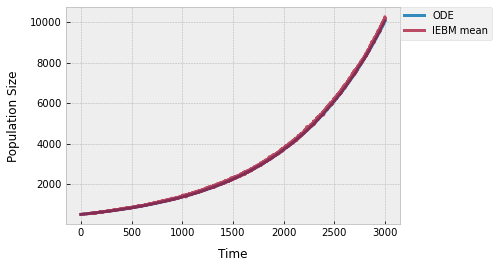

In [11]:
ds = dt.rbind([dt.Frame(time=r[0], pop=r[1]) for r in res])
ds['time_int'] = ds[:, dt.int64(dt.f.time)]
time_pop = ds[:, dt.mean(dt.f.pop), dt.by(dt.f.time_int)].to_numpy()

fig, ax = plt.subplots()
ax.plot(ode_times, ode_pop, label='ODE', lw=3)
ax.plot(time_pop[:,0], time_pop[:,1], alpha=0.7, lw=3, label='IEBM mean')

ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()